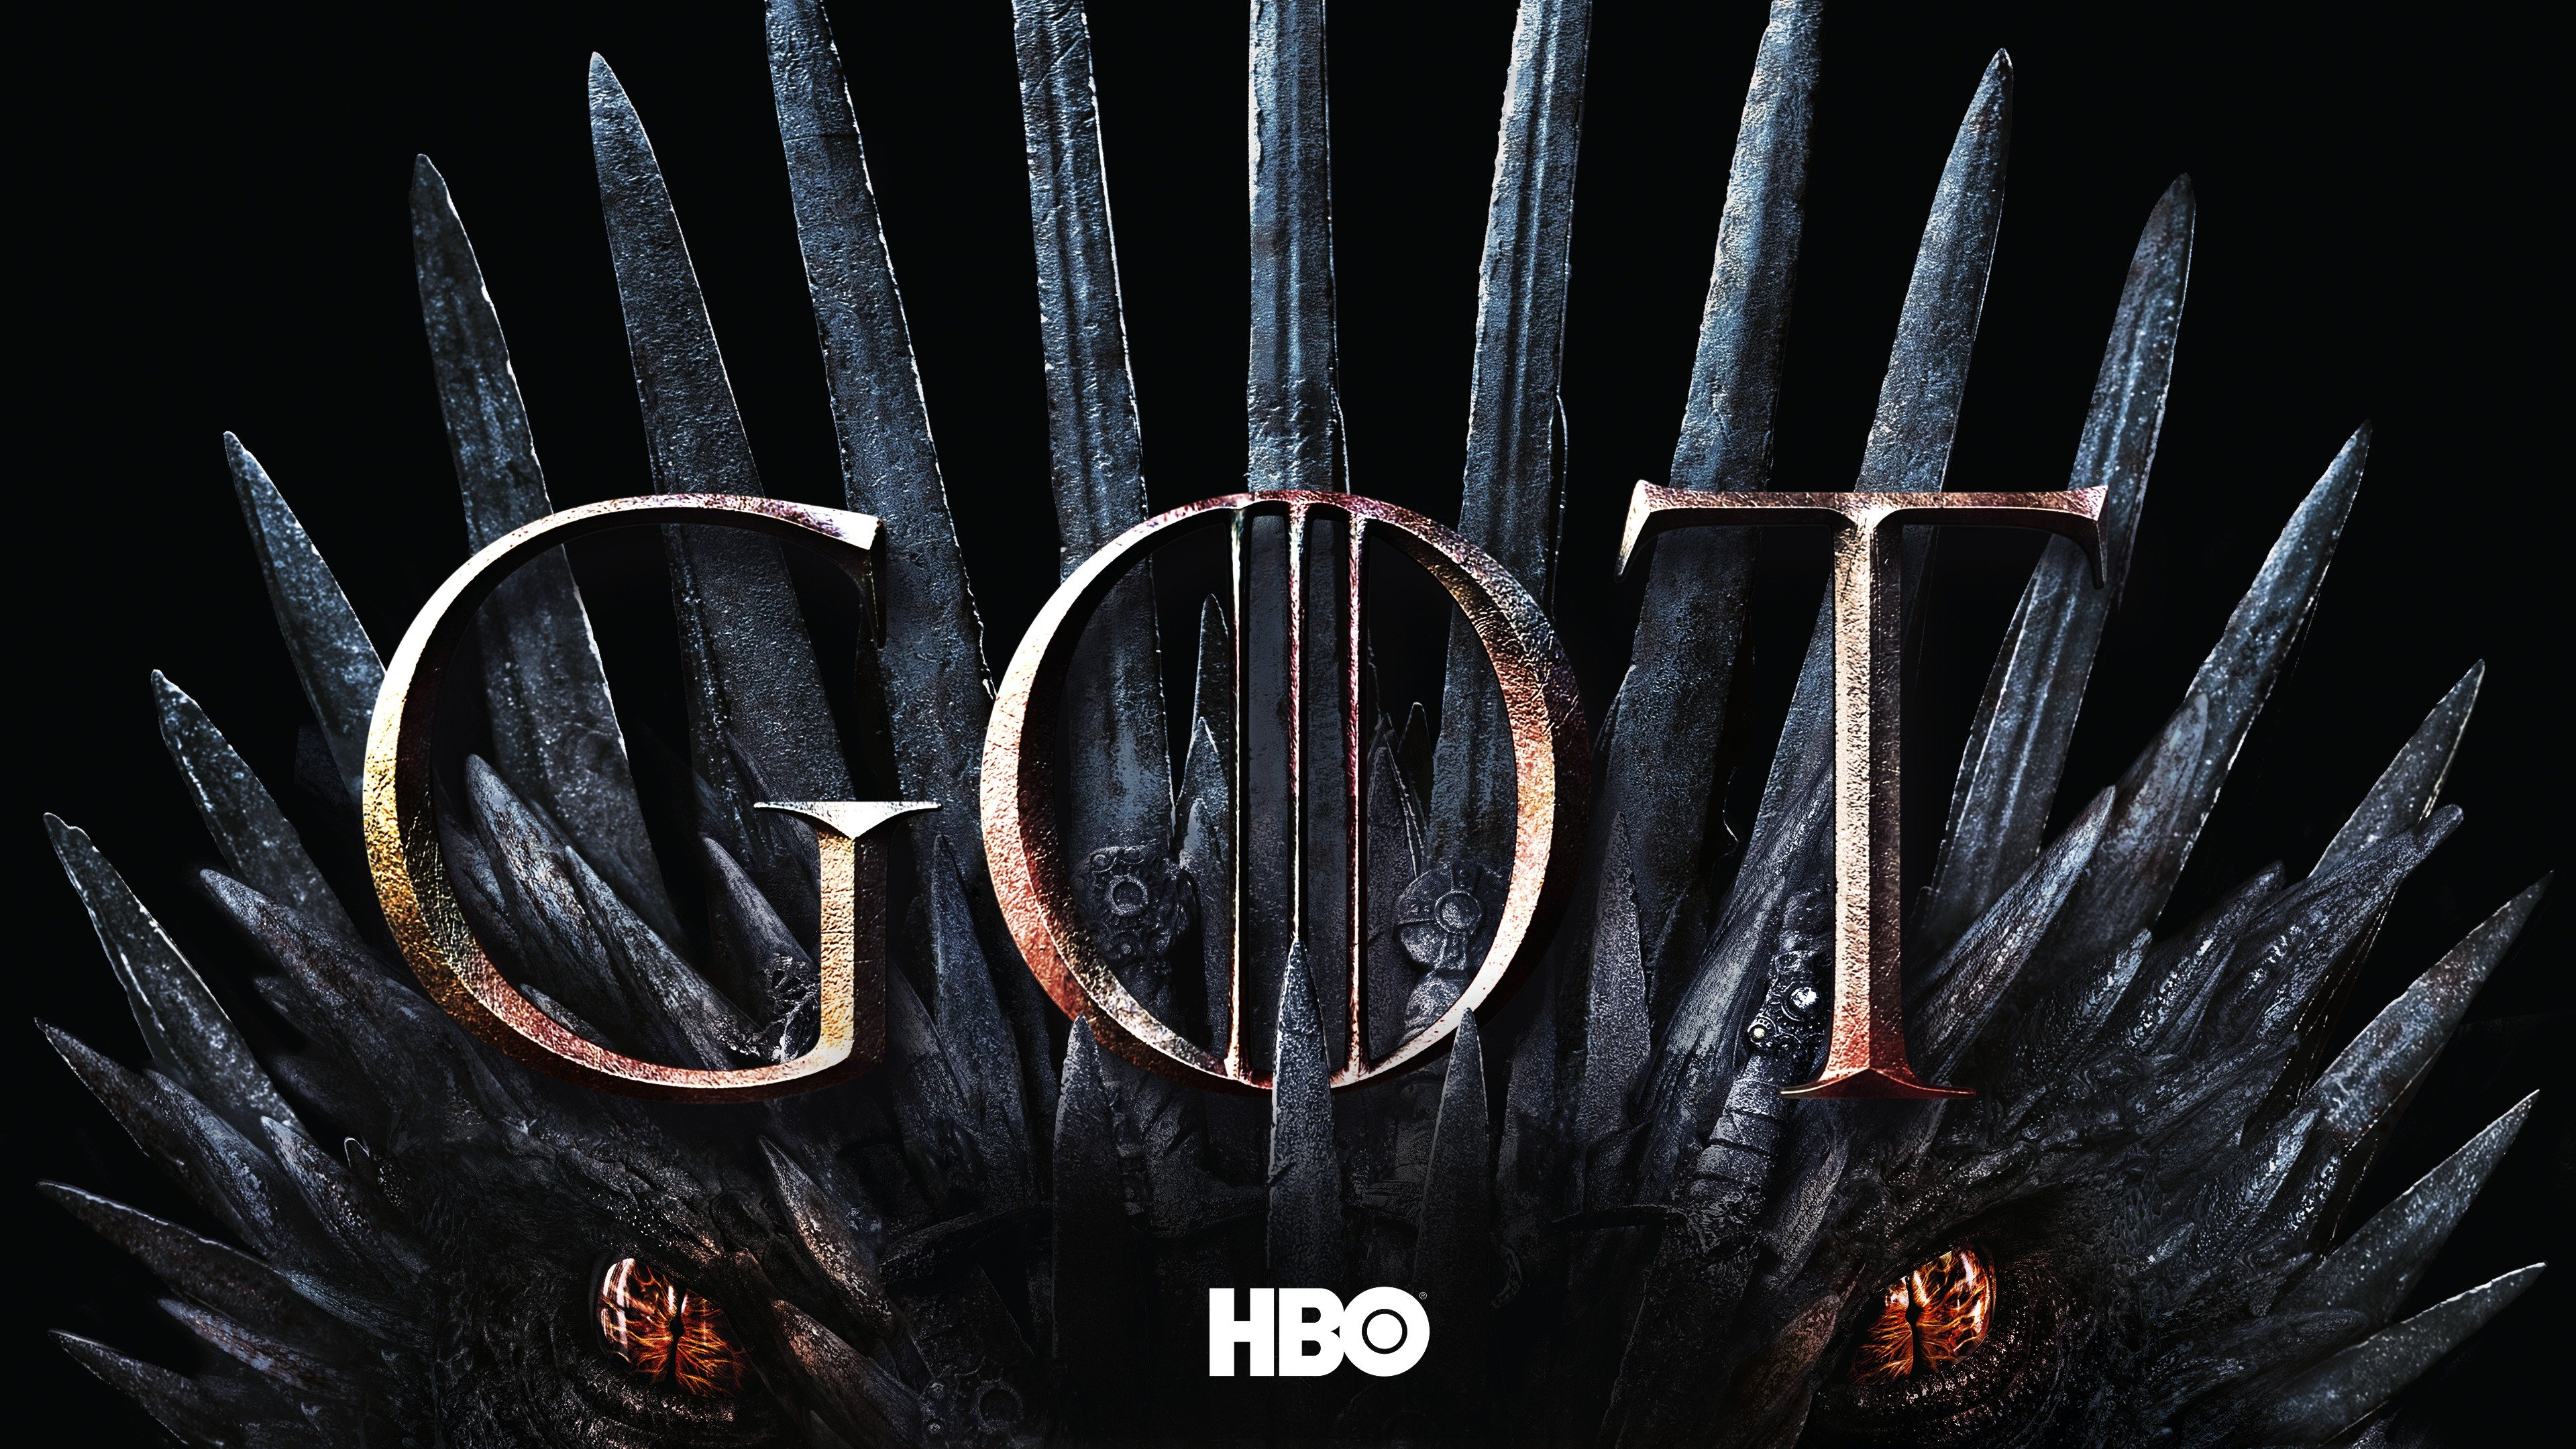

# Project 14 - Game of Thrones deaths - Logistical Regression Model

## Table of contents

- [Step 1](#step_1): Import libraries
- [Step 2](#step_2): Read dataset
- [Step 3](#step_3): Prepare features
- [Step 4](#step_4): Build model
- [Step 5](#step_5): Optimize model is regularization 

<a id=’step_1’></a>
## Step 1: Import libraries

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import train_test_split

<a id=’step_2’></a>
## Step 2: Read dataset

In [2]:
DATA_PATH = Path.cwd().parent.joinpath('data')
filename = Path.joinpath(DATA_PATH, 'asoiaf_book_deaths.csv')
print(filename)
df = pd.read_csv(filename)
df.head()

/home/studio-lab-user/intuit-ga-dat17/projects/ds-project-14/data/asoiaf_book_deaths.csv


,Name,Allegiances,Book Intro Chapter,Gender,Nobility,GoT,CoK,SoS,FfC,DwD,died
0,Addam Marbrand,Lannister,56.0,1,1,1,1,1,1,0,0
1,Aegon Frey (Jinglebell),None,49.0,1,1,0,0,1,0,0,1
2,Aegon Targaryen,House Targaryen,5.0,1,1,0,0,0,0,1,0
3,Adrack Humble,House Greyjoy,20.0,1,1,0,0,0,0,1,1
4,Aemon Costayne,Lannister,NaN,1,1,0,0,1,0,0,0


In [3]:
#917 rows
df.shape

(917, 11)

In [4]:
# ~30% death rate
df['died'].value_counts()

0    612
1    305
Name: died, dtype: int64

In [5]:
# drop Name to make things easier
df = df.drop('Name', axis=1)
df.head()

,Allegiances,Book Intro Chapter,Gender,Nobility,GoT,CoK,SoS,FfC,DwD,died
0,Lannister,56.0,1,1,1,1,1,1,0,0
1,None,49.0,1,1,0,0,1,0,0,1
2,House Targaryen,5.0,1,1,0,0,0,0,1,0
3,House Greyjoy,20.0,1,1,0,0,0,0,1,1
4,Lannister,NaN,1,1,0,0,1,0,0,0


In [6]:
# Let's do the same with Book Intro Chapter
df = df.drop('Book Intro Chapter', axis=1)
df.head()

,Allegiances,Gender,Nobility,GoT,CoK,SoS,FfC,DwD,died
0,Lannister,1,1,1,1,1,1,0,0
1,None,1,1,0,0,1,0,0,1
2,House Targaryen,1,1,0,0,0,0,1,0
3,House Greyjoy,1,1,0,0,0,0,1,1
4,Lannister,1,1,0,0,1,0,0,0


In [7]:
# rename column I want to predict
df.rename(columns = {'died':'y'}, inplace = True)
df.head()

,Allegiances,Gender,Nobility,GoT,CoK,SoS,FfC,DwD,y
0,Lannister,1,1,1,1,1,1,0,0
1,None,1,1,0,0,1,0,0,1
2,House Targaryen,1,1,0,0,0,0,1,0
3,House Greyjoy,1,1,0,0,0,0,1,1
4,Lannister,1,1,0,0,1,0,0,0


In [8]:
df.describe()

,Gender,Nobility,GoT,CoK,SoS,FfC,DwD,y
count,917.000000,917.000000,917.000000,917.000000,917.000000,917.000000,917.000000,917.000000
mean,0.828790,0.468920,0.272628,0.353326,0.424209,0.272628,0.284624,0.332606
std,0.376898,0.499305,0.445554,0.478264,0.494492,0.445554,0.451481,0.471404
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


<a id=’step_3’></a>
## Step 3: Prepare features

In [9]:
features = ['Allegiances','Gender','Nobility','y']
for feat in features:
    if feat != 'age':
        print(df[feat].value_counts())

None               253
Night's Watch      116
Lannister           81
Stark               73
Baratheon           56
Greyjoy             51
Wildling            40
House Stark         35
Martell             25
House Greyjoy       24
Arryn               23
Tully               22
House Lannister     21
House Targaryen     19
Targaryen           17
Tyrell              15
House Martell       12
House Tyrell        11
House Tully          8
House Baratheon      8
House Arryn          7
Name: Allegiances, dtype: int64
1    760
0    157
Name: Gender, dtype: int64
0    487
1    430
Name: Nobility, dtype: int64
0    612
1    305
Name: y, dtype: int64


In [10]:
# Allegiance needs some cleaning

df.loc[:,"Allegiances"] = df.loc[:,"Allegiances"].str.replace("House ","")


In [11]:
df["Allegiances"].value_counts()

None             253
Night's Watch    116
Stark            108
Lannister        102
Greyjoy           75
Baratheon         64
Wildling          40
Martell           37
Targaryen         36
Arryn             30
Tully             30
Tyrell            26
Name: Allegiances, dtype: int64

Since most columns are 1's and 0's, I only need to create a dummies for Allegiances

In [12]:
model = pd.get_dummies(df[['Allegiances','Gender','Nobility','y']], drop_first = True)
model.head()

,Gender,Nobility,y,Allegiances_Baratheon,Allegiances_Greyjoy,Allegiances_Lannister,Allegiances_Martell,Allegiances_Night's Watch,Allegiances_None,Allegiances_Stark,Allegiances_Targaryen,Allegiances_Tully,Allegiances_Tyrell,Allegiances_Wildling
0,1,1,0,0,0,1,0,0,0,0,0,0,0,0
1,1,1,1,0,0,0,0,0,1,0,0,0,0,0
2,1,1,0,0,0,0,0,0,0,0,1,0,0,0
3,1,1,1,0,1,0,0,0,0,0,0,0,0,0
4,1,1,0,0,0,1,0,0,0,0,0,0,0,0


<a id=’step_4’></a>
## Step 4: Build model

In [13]:
# set x and y
y = model['y']
print(y.shape)

X = model.drop('y', axis=1)
print(X.shape)


(917,)
(917, 13)


In [22]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=42)

# fit model
logreg = LogisticRegression(max_iter=200) 
logreg.fit(X_train, y_train)

LogisticRegression(max_iter=200)

In [23]:
#what are the coefficients?
feature_cols = X.columns
coeffs=pd.DataFrame(list(zip(feature_cols, logreg.coef_[0])), columns=['feature','coef'])
coeffs.set_index('feature', inplace=True)
coeffs.sort_values('coef', ascending=False).head(15)

,coef
feature,
Allegiances_Wildling,1.222336
Allegiances_Stark,0.759617
Gender,0.592868
Allegiances_Night's Watch,0.525148
Allegiances_Baratheon,0.510327
Allegiances_Greyjoy,0.218397
Allegiances_Lannister,0.109043
Allegiances_None,0.069508
Allegiances_Tully,-0.019533


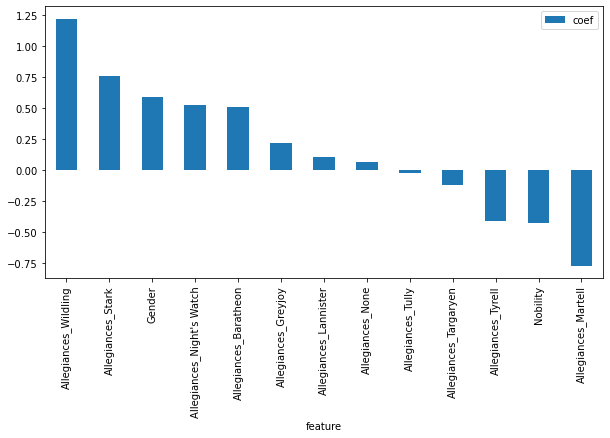

In [24]:
# display the coefficients as a bar chart
coeffs.sort_values('coef', ascending=False).plot(kind='bar', figsize=(10,5));

Insights:
- Nobles are less likely to die... especially the Martells
- Men are more likely to die...
- Wildlings and Startks are most likely to die. Would be interesting to bring in Location - seems like farther north the house is from, the more likely to die (farther confirmed by Martell being the least likely) 

In [25]:
# predict on the testing dataset
y_preds=logreg.predict(X_test)
print('preds', list(y_preds[:10]))
print('truth', list(y_test[:10]))

preds [1, 0, 0, 1, 0, 0, 0, 0, 0, 0]
truth [1, 0, 1, 0, 1, 1, 1, 0, 1, 0]


In [26]:
# The model is not very accurate... 
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score, log_loss
print(accuracy_score(y_preds, y_test))

0.7260869565217392


In [19]:
## 162 true negatives, 6 true positives, and 57 false negatives and 5 false positives... it's predicting being alive vast majority of the time
print(f'Accuracy: {accuracy_score(y_test,y_preds)}')
print()
print(f'Confusion Matrix:\n {confusion_matrix(y_test,y_preds)}')
print()
print(f'ROC-AUC Score: {roc_auc_score(y_test,y_preds)}')
print()
print(f'Log Loss: {log_loss(y_test,y_preds)}')


Accuracy: 0.7260869565217392

Confusion Matrix:
 [[162   6]
 [ 57   5]]

ROC-AUC Score: 0.5224654377880183

Log Loss: 9.460642219408497


In [20]:
# compare to baseline
baseline_preds = np.empty(len(y_test))
baseline_preds.fill(False)
print(accuracy_score(baseline_preds, y_test))

0.7304347826086957


In [ ]:
# the model is similar/slightly worse than the baseline.

<a id=’step_5’></a>
## Step 5: Optimize model with regularization 

In [27]:
# X and y features
y2 = model['y']
X2 = model.drop('y', axis=1)

In [34]:
# using train test split to cross val
x_train2, x_test2, y_train2, y_test2 = train_test_split(X2,y2, random_state =42)

cees = [0.01, 0.1, 1.0, 10, 100]

print('ROC : C')
for c in cees:
    logreg2 = LogisticRegression(penalty='l2', C=c, max_iter=2500) # set max_iter to avoid warning
    logreg2.fit(x_train2,y_train2)
    y_pred2 = logreg.predict(x_test2)
    roc = metrics.roc_auc_score(y_test2, y_pred2)
    print(roc," : ", c)

ROC : C
0.5224654377880183  :  0.01
0.5224654377880183  :  0.1
0.5224654377880183  :  1.0
0.5224654377880183  :  10
0.5224654377880183  :  100


In [36]:
#compare accuracies 
print(accuracy_score(y_test2, y_pred2))
print(accuracy_score(y_test2, y_pred2))

0.7260869565217392
0.7260869565217392


In [ ]:
# Regularization doesn't seem to make a difference...

## Scratch work - testing out new column

In [ ]:
# I wonder if adding another features (books) would work

In [45]:
# Clash of Kings and Storm of Swords were the deadlinest - create new column that flags based on those 2

df2 = df
df2['in_CoK_SoS'] =  df2[["CoK",'SoS']].max(axis=1)
df2.head()

,Allegiances,Gender,Nobility,GoT,CoK,SoS,FfC,DwD,y,in_books,in_CoK_SoS
0,Lannister,1,1,1,1,1,1,0,0,1,1
1,None,1,1,0,0,1,0,0,1,1,1
2,Targaryen,1,1,0,0,0,0,1,0,1,0
3,Greyjoy,1,1,0,0,0,0,1,1,1,0
4,Lannister,1,1,0,0,1,0,0,0,1,1


In [47]:
df2['in_CoK_SoS'].value_counts()

1    576
0    341
Name: in_CoK_SoS, dtype: int64

In [49]:
model3 = pd.get_dummies(df[['Allegiances','Gender','Nobility','in_CoK_SoS','y']], drop_first = True)
model3.head()

,Gender,Nobility,in_CoK_SoS,y,Allegiances_Baratheon,Allegiances_Greyjoy,Allegiances_Lannister,Allegiances_Martell,Allegiances_Night's Watch,Allegiances_None,Allegiances_Stark,Allegiances_Targaryen,Allegiances_Tully,Allegiances_Tyrell,Allegiances_Wildling
0,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0
1,1,1,1,1,0,0,0,0,0,1,0,0,0,0,0
2,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0
3,1,1,0,1,0,1,0,0,0,0,0,0,0,0,0
4,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0


In [50]:
# set x and y
y3 = model3['y']
X3 = model3.drop('y', axis=1)

# train test split
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y3, test_size = 0.25, random_state=42)

# fit model
logreg3 = LogisticRegression(max_iter=200) 
logreg3.fit(X_train3, y_train3)

LogisticRegression(max_iter=200)

In [51]:
#what are the coefficients? any different than before?
feature_cols3 = X3.columns
coeffs3=pd.DataFrame(list(zip(feature_cols3, logreg3.coef_[0])), columns=['feature','coef'])
coeffs3.set_index('feature', inplace=True)
coeffs3.sort_values('coef', ascending=False).head(15)

,coef
feature,
Allegiances_Wildling,1.216099
Allegiances_Stark,0.747424
Gender,0.617516
in_CoK_SoS,0.435306
Allegiances_Night's Watch,0.397145
Allegiances_Baratheon,0.368590
Allegiances_Greyjoy,0.249509
Allegiances_Lannister,0.036076
Allegiances_None,0.026747


In [52]:
#slightly different
# predict on the testing dataset
y_preds=logreg.predict(X_test)
print('preds', list(y_preds[:10]))
print('truth', list(y_test[:10]))

preds [1, 0, 0, 1, 0, 0, 0, 0, 0, 0]
truth [1, 0, 1, 0, 1, 1, 1, 0, 1, 0]


In [53]:
print(f'Accuracy: {accuracy_score(y_test,y_preds)}')
print()
print(f'Confusion Matrix:\n {confusion_matrix(y_test,y_preds)}')
print()
print(f'ROC-AUC Score: {roc_auc_score(y_test,y_preds)}')
print()
print(f'Log Loss: {log_loss(y_test,y_preds)}')

Accuracy: 0.7260869565217392

Confusion Matrix:
 [[162   6]
 [ 57   5]]

ROC-AUC Score: 0.5224654377880183

Log Loss: 9.460642219408497


In [ ]:
# this did not make a difference either